# Voxel time courses

When we have a 4D image, we can think of the data in several ways.  For
example the data could be:

* A series of 3D volumes (slicing over the last axis);

* A collection of 1D voxel time courses (slicing over the first three axes).

For this notebook you will need:

* [ds114 FMRI image]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1.nii).
* [ds114 stimulus file]({{ site.url }}{{ site.baseurl }}/data/ds114_sub009_t2r1_cond.txt).

In [1]:
# Our usual set-up
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Display array values to 4 digits of precision
np.set_printoptions(precision=4, suppress=True)

We load a 4D file:

In [2]:
import nibabel as nib
img = nib.load('ds114_sub009_t2r1.nii')
img.shape

(64, 64, 30, 173)

We drop the first volume; as you remember, the first volume is very different
from the rest of the volumes in the series:

In [3]:
# Drop the first volume
data = img.get_data()
data = data[..., 1:]
data.shape

(64, 64, 30, 172)

We can think of this 4D data as a series of 3D volumes.  That is the way we
have been thinking of the 4D data so far:

In [4]:
# This is slicing over the last (time) axis
vol0 = data[..., 0]
vol0.shape

(64, 64, 30)

We can also index over the first three axes.  The first three axes in this
array represent space.

* The first axis goes from right to left (0 index value means right, 63 means
  left);

* The second axis goes from back to front (0 index value means back, 63 means
  front);

* The third axes goes from bottom to top (0 means bottom, 29 means top).

If you give me index values for these first three axes, you have given me a
*coordinate* in the first three axes of the array.

For example, you could give me an index tuple for the first three axes like
this: `(42, 32, 19)`.  The first index of 42 refers to a position towards
the left of the brain (> 31).  The second index of 32 refers to a position
almost in the center front to back.  The last index of 19 refers to a position
a little further towards the top of the brain – in this image.

This coordinate therefore refers to a particular part of the image:

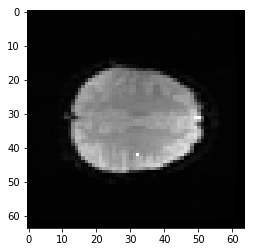

In [5]:
# Where is this in the brain?
mean_data = np.mean(data, axis=-1)
# Make a nice bright dot in the right place
mean_data[42, 32, 19] = np.max(mean_data)
plt.imshow(mean_data[:, :, 19], cmap='gray', interpolation='nearest')

If I slice into the data array with these coordinates, I will get a vector,
with the image value at that position (43, 32, 19), for every point in time:

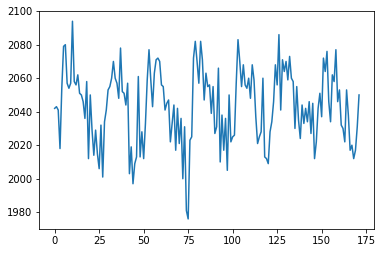

In [6]:
# This is slicing over all three of the space axes
voxel_time_course = data[42, 32, 19, :]
voxel_time_course.shape
plt.plot(voxel_time_course);

We could call this a “voxel time course”.

We might want to do ordinary statistical type things with this time course.
For example, we might want to correlate this time course with a measure of
whether the subject was doing the task or not.

This measure will have 1 for each volume (time point) where the subject was
doing the task, and 0 for each volume where the subject was at rest.

We call this a “neural” time course, because we believe that the nerves in the
relevant brain area will switch on when the task starts (value = 1) and then
switch off when the task stops (value = 0).

To get this on-off measure, we first need to load the stimulus file, and work out the scan numbers at which each block started and ended.

The stimulus file is `ds114_sub009_t2r1_cond.txt`.

In fact, it has times in *seconds*, not scans.

We will need to use the *TR* to convert between seconds and scan numbers.

Remember, the TR is the Time to Repeat, and, for an Echo Planar run (like an FMRI run), it is the time from the start of acquisition of one volume, and the start of acquisition of the next.

In [7]:
TR = 2.5  # time between volumes

Now we can create a vector of ones and zeros, with one value for each scan.
1 means the scan was during the activation block, and 0 means the scan was
during a rest block.


In [8]:
#- Make new zero vector for neural prediction
neural_prediction = np.zeros(img.shape[-1])
#- Read the file into an array called "task".
#- "task" should have 3 columns (onset, duration, amplitude)
task = np.loadtxt('ds114_sub009_t2r1_cond.txt')
#- Select first two columns and divide by TR
ons_durs = task[:, :2] / TR
#- Fill in values of 1 for positions of on blocks in time course
# Convert onsets, durations to integers first
ons_durs = np.round(ons_durs).astype(int)
for onset, duration in ons_durs:
    neural_prediction[onset:onset + duration] = 1

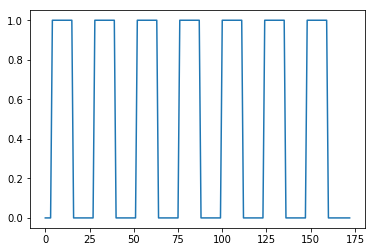

In [9]:
plt.plot(neural_prediction);

Here we plot the voxel time course against this neural prediction:

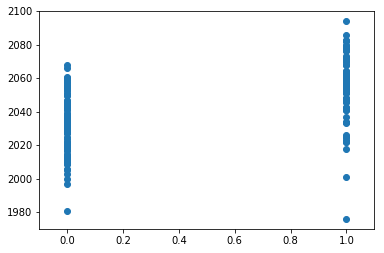

In [10]:
# Plot the neural prediction against the data
neural_prediction = neural_prediction[1:]
# Notice the 'o' to specify the "line marker"
plt.plot(neural_prediction, voxel_time_course, 'o')
# Set the axis limits to give space on left and right
axis = plt.gca()
axis.set_xlim(-0.1, 1.1);

We can look at the correlation between the on-off prediction and the voxel
time course:

In [11]:
# Correlate the neural time course with the voxel time course
np.corrcoef(neural_prediction, voxel_time_course)

array([[1.    , 0.5429],
       [0.5429, 1.    ]])